## Test migration history reconstruction on tracerx nsclc patients with anatomical site information (so we can use our organotropism prior)

In [1]:
import sys
import os

REPO_DIR = os.path.join(os.getcwd(), "../../")
os.chdir(REPO_DIR)

from src.lib.metient import *
from src.util import data_extraction_util as dutil

import matplotlib
import torch
import pandas as pd
import numpy as np

custom_colors = ["#9e9e9e","#c27ba0", "#be5742e1", "#6fa8dc", "#e69138", "#6aa84f"]
TRACERX_DATA_DIR = os.path.join(REPO_DIR, 'src/data/tracerx_nsclc/')
PYCLONE_CLUSTERED_TSVS_DIR = os.path.join(TRACERX_DATA_DIR, 'patient_data', 'pyclone_clustered')
CONIPHER_TREES_DIR = os.path.join(TRACERX_DATA_DIR, 'conipher_outputs', 'TreeBuilding')
MSK_MET_FN = os.path.join(REPO_DIR, 'src/data/msk_met/msk_met_freq_by_cancer_type.csv')
OUTPUT_DIR = os.path.join(TRACERX_DATA_DIR, "metient_outputs")

CUDA GPU: False


### Get metastatic site frequency counts from tracerx paper (https://www.nature.com/articles/s41586-023-05729-x/figures/1)

In [2]:

tracerx_reported_counts = {
    "Brain":6, "Chest wall":1, "Bronchus":4,"Pleura":2,"Rib":2,
    "Liver":6,"Flank":1,"Femur":1,"Neck LN":2,"Primary LN":148,
    "Recurrence LN":20,"Scapula":1,"Axillary LN":1,"Recurrence lung":13,
    "Primary surgery satellite lesion lung":3, "Adrenal gland":1,
    "Subphrenic mass":1, "Skin":3, "Paravertebral":1, "Peritnoeum":1,
    "Lung":0
}

total = sum([tracerx_reported_counts[key] for key in tracerx_reported_counts])
tracerx_reported_freqs = {key:float(tracerx_reported_counts[key]/total) for key in tracerx_reported_counts}
print(tracerx_reported_freqs)
def get_organotropism_matrix_from_tracerx(unique_sites, tracerx_map):
    mapped_sites = [tracerx_map[site] for site in unique_sites]
    organotrop_arr = np.zeros(len(mapped_sites))
    for i, metastatic_site in enumerate(mapped_sites):
        organotrop_arr[i] = tracerx_reported_freqs[metastatic_site]
    return torch.tensor(organotrop_arr, dtype = torch.float32)

    

{'Brain': 0.027522935779816515, 'Chest wall': 0.0045871559633027525, 'Bronchus': 0.01834862385321101, 'Pleura': 0.009174311926605505, 'Rib': 0.009174311926605505, 'Liver': 0.027522935779816515, 'Flank': 0.0045871559633027525, 'Femur': 0.0045871559633027525, 'Neck LN': 0.009174311926605505, 'Primary LN': 0.6788990825688074, 'Recurrence LN': 0.09174311926605505, 'Scapula': 0.0045871559633027525, 'Axillary LN': 0.0045871559633027525, 'Recurrence lung': 0.05963302752293578, 'Primary surgery satellite lesion lung': 0.013761467889908258, 'Adrenal gland': 0.0045871559633027525, 'Subphrenic mass': 0.0045871559633027525, 'Skin': 0.013761467889908258, 'Paravertebral': 0.0045871559633027525, 'Peritnoeum': 0.0045871559633027525, 'Lung': 0.0}


In [3]:
def find_labeling(ref_var_fn, tree, custom_colors, primary_site, patient_name, output_dir, msk_met_map, tracerx_map, sites_map, weights):    
    ref_matrix, var_matrix, unique_sites, idx_to_full_cluster_label = get_ref_var_matrices(ref_var_fn)

    idx_to_cluster_label = dict()
    for ix in idx_to_full_cluster_label:
        og_label_muts = idx_to_full_cluster_label[ix].split(';') # e.g. CUL3:2:225371655:T;TRPM6:9:77431650:C
        if len(og_label_muts) > 3:
            og_label_muts = og_label_muts[:3]
        gene_names = []
        for mut_label in og_label_muts:
            gene_names.append(mut_label.split(":")[0])
        idx_to_cluster_label[ix] = ("_").join(gene_names)
    print(idx_to_cluster_label)
    print(tree.shape)
    G = get_genetic_distance_matrix_from_adj_matrix(tree,idx_to_full_cluster_label, ";")
    if weights.gen_dist == 0.0:
        G = None
    #O = get_organotropism_matrix_from_msk_met(unique_sites, "Non-Small Cell Lung Cancer", MSK_MET_FN, msk_met_map)
    O = get_organotropism_matrix_from_tracerx(unique_sites, tracerx_map)
    print("O", O)
    if weights.organotrop == 0.0:
        O = None
    unique_sites = [sites_map[site] for site in unique_sites]
    print(f"Anatomical sites: {unique_sites}")   

    print_config = PrintConfig(visualize=True, verbose=False, viz_intermeds=False, k_best_trees=6)
    get_migration_history(tree, ref_matrix, var_matrix, unique_sites, "Lung", idx_to_cluster_label,
                          weights, print_config, output_dir, patient_name, G=G, O=O,
                          weight_init_primary=True, custom_colors=custom_colors, 
                          batch_size=8000, max_iter=50, solve_polytomies=False, mode='evaluate')

    
def run_conipher_patient(patient, weights, tsv_dir, tree_dir, msk_met_map, tracerx_map, sites_map, output_dir):
    space = "x"*44
    tsv_fn = os.path.join(tsv_dir, f"{patient}_clustered_SNVs.tsv")
    print(f"{space} PATIENT {patient} {space}")
    df = pd.read_csv(tsv_fn, delimiter="\t")
    primary_sites = list(df[df['sample_type']=='primary']['anatomical_site_label'].unique())
    if (len(primary_sites) > 1):
        print("*Multiple primary samples, running metient once for each possible primary*")
    for primary_site in primary_sites:
        print(f"Primary site: {primary_site}")
        run_name = f"{patient}_{primary_site}"
        tree_fn = os.path.join(tree_dir, f"{patient}_conipher_SNVsallTrees_cleaned.txt")
        trees = dutil.get_adj_matrices_from_all_conipher_trees(tree_fn)
        find_labeling(tsv_fn, trees[0], custom_colors, primary_site, run_name, output_dir, msk_met_map, tracerx_map, sites_map, weights)


In [11]:
def find_labeling(ref_var_fn, tree, custom_colors, primary_site, patient_name, output_dir, weights):    
    ref_matrix, var_matrix, unique_sites, idx_to_full_cluster_label = get_ref_var_matrices(ref_var_fn)

    idx_to_cluster_label = dict()
    for ix in idx_to_full_cluster_label:
        og_label_muts = idx_to_full_cluster_label[ix].split(';') # e.g. CUL3:2:225371655:T;TRPM6:9:77431650:C
        if len(og_label_muts) > 3:
            og_label_muts = og_label_muts[:3]
        gene_names = []
        for mut_label in og_label_muts:
            gene_names.append(mut_label.split(":")[0])
        idx_to_cluster_label[ix] = ("_").join(gene_names)
    print(idx_to_cluster_label)
    print(tree.shape)
    G = get_genetic_distance_matrix_from_adj_matrix(tree,idx_to_full_cluster_label, ";")
    if weights.gen_dist == 0.0:
        G = None
    
    print(f"Anatomical sites: {unique_sites}")   

    print_config = PrintConfig(visualize=True, verbose=False, viz_intermeds=False, k_best_trees=6)
    get_migration_history(tree, ref_matrix, var_matrix, unique_sites, "primary_SU_T1", idx_to_cluster_label,
                          weights, print_config, output_dir, patient_name, G=G, O=None,
                          weight_init_primary=True, custom_colors=custom_colors, 
                          batch_size=8000, max_iter=50, solve_polytomies=True, mode='evaluate')

    
def run_conipher_patient(patient, weights, tsv_dir, tree_dir, output_dir):
    space = "x"*44
    tsv_fn = os.path.join(tsv_dir, f"{patient}_clustered_SNVs.tsv")
    print(f"{space} PATIENT {patient} {space}")
    df = pd.read_csv(tsv_fn, delimiter="\t")
    primary_sites = list(df[df['sample_type']=='primary']['anatomical_site_label'].unique())
    if (len(primary_sites) > 1):
        print("*Multiple primary samples, running metient once for each possible primary*")
    for primary_site in primary_sites:
        print(f"Primary site: {primary_site}")
        run_name = f"{patient}_{primary_site}"
        tree_fn = os.path.join(tree_dir, f"{patient}_conipher_SNVsallTrees_cleaned.txt")
        trees = dutil.get_adj_matrices_from_all_conipher_trees(tree_fn)
        find_labeling(tsv_fn, trees[0], custom_colors, primary_site, run_name, output_dir, weights)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx PATIENT CRUK0484 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Primary site: primary_SU_T1
{0: 'TMPRSS12_MILR1_SLC7A10', 1: 'EIF4E2_PKHD1L1_FAP', 2: 'RAPGEF2_UBA6_TMEM132D', 3: 'TRAPPC6B_ZEB2_ELMOD1', 4: 'PSMA7_ATP1A1_CPVL', 5: 'PDE7A_HK3_TENM2', 6: 'CHGB_DDI2_ZNF792', 7: 'PEX2_AGTPBP1_CYB5A', 8: 'PCDHGB2_CSPG4_STEAP2', 9: 'PML_XIRP1_MUC16', 10: 'SLIT1_KIAA1598_CSTF2T', 11: 'RNF44_CACNA1E_EPHB6', 12: 'PCDHGA12_LRP6_NRP1', 13: 'MYL2_KCTD7_FRMD3', 14: 'TDRD6_PAX5_SLC26A10', 15: 'PTPRA_PTPRT_MUC16', 16: 'CHRNA4_WNT6_LBP', 17: 'SECISBP2_CELF4_NTNG2', 18: 'STON1_TNC_MKL1', 19: 'HACE1_SLC35D2_CENPF', 20: 'FN1_RNU6-71P_DLGAP2', 21: 'GHSR_TMED3_ZNF254', 22: 'TOP3B_TDRD5_CHAF1B', 23: 'ITGA1_SHROOM1_MALRD1', 24: 'PABPC1_OR5R1_FAT1', 25: 'FAM83E_MYOM2_KATNBL1', 26: 'PKHD1_DHRS9_TSPAN1', 27: 'SAP30L-AS1_BCAP29_USP4', 28: 'PLEKHH1_ZNF318_OTOF', 29: 'GJA8_VPS45_FBXO32', 30: 'CD109_DISC1_LRRC43', 31: 'ZNF254_EDN3_SLX4', 32: 'NLRP11_NUTF2_AKNA'}
torch.Size([

/lila/data/morrisq/divyak/projects/met_history_prediction/src/util/vertex_labeling_util.py:258: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)


nodes_w_polys [0, 2, 3, 5, 7, 10, 11, 20] resolver_sites [[5, 1], [1], [2, 5], [0], [3, 4], [5, 4, 2], [4], [5]]
num_new_nodes 13
children_of_polys [10, 20, 46, 51, 14, 19, 21, 52, 71, 1, 29, 58, 66, 72, 4, 6, 48, 73, 11, 12, 61, 67, 2, 3, 53, 59, 62, 68, 74, 16, 28, 69, 5, 50, 75]
resolver_indices [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
nodes_w_polys_to_resolver_indices OrderedDict([(0, [33, 34]), (2, [35]), (3, [36, 37]), (5, [38]), (7, [39, 40]), (10, [41, 42, 43]), (11, [44]), (20, [45])])
resolver_labeling tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.]])
parent_idx 0 mask_indices [33, 34, 0]
parent_idx 2 mask_indices [35, 2]
parent_idx 3 mask_indices

  0%|          | 0/50 [00:00<?, ?it/s]/lila/data/morrisq/divyak/projects/met_history_prediction/src/util/vertex_labeling_util.py:249: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A, remove_self_loops=True), dtype = torch.float32)
100%|██████████| 50/50 [04:29<00:00,  5.38s/it]


num solutions 8000
best_sum_by_weights {(10.0, 1.0): 31.0}
bs 8000
pruned solutions 3


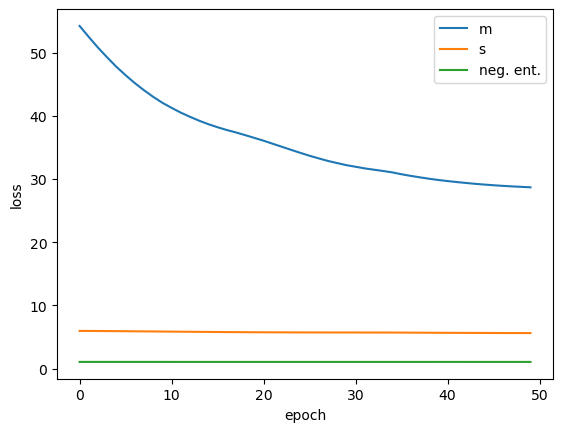

6 unique trees were not found (3 were found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

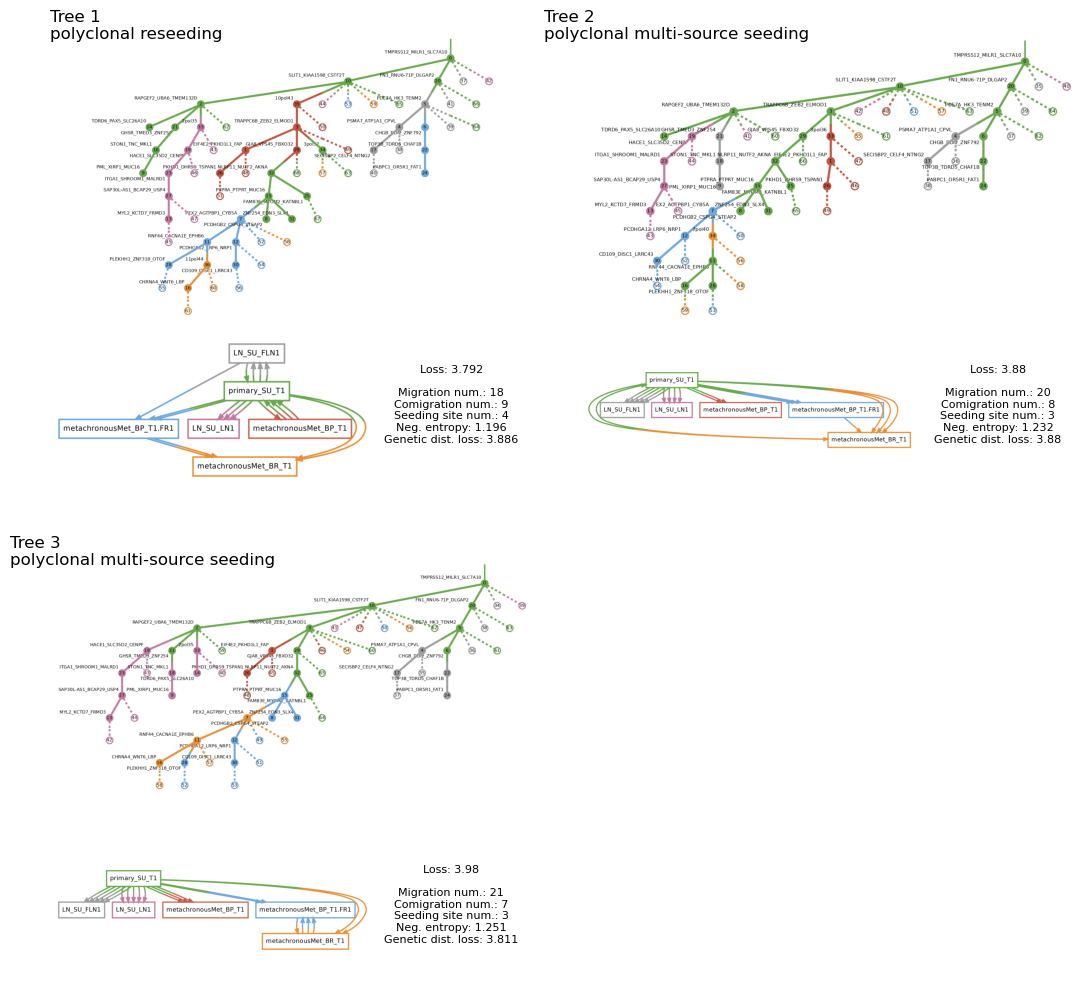

In [12]:
weights = Weights(mig=[10], mig_delta=0.8, seed_site=[1], gen_dist=0.1, organotrop=0.0)

run_conipher_patient("CRUK0484", weights, PYCLONE_CLUSTERED_TSVS_DIR, CONIPHER_TREES_DIR, OUTPUT_DIR)

### CRUK0484 with organotropism info

In [4]:
%time
CRUK0484_tracerx_map = {
    "primary_SU_T1" : "Lung",
    "LN_SU_FLN1" : "Primary LN",
    "LN_SU_LN1" : "Primary LN",
    "metachronousMet_BP_T1" : "Brain",
    "metachronousMet_BP_T1.FR1" : "Scapula",
    "metachronousMet_BR_T1" : "Rib"
}

CRUK0484_msk_met_map = {
    "primary_SU_T1" : "Lung",
    "LN_SU_FLN1" : "Distant LN",
    "LN_SU_LN1" : "Distant LN",
    "metachronousMet_BP_T1" : "CNS/Brain",
    "metachronousMet_BP_T1.FR1" : "Bone",
    "metachronousMet_BR_T1" : "Bone"
}

# For visualization on migraiton graph
sites_map = {
    "primary_SU_T1" : "Lung",
    "LN_SU_FLN1" : "Lymph Node 1",
    "LN_SU_LN1" : "Lymph Node 2",
    "metachronousMet_BP_T1" : "Brain",
    "metachronousMet_BP_T1.FR1" : "Scapula",
    "metachronousMet_BR_T1" : "Rib"
}

#weights = Weights(data_fit=0.2, mig=10.0, comig=7.0, seed_site=5.0, reg=3.0, gen_dist=2.0, organotrop=2.0)
weights = Weights(mig=[10], mig_delta=0.8, seed_site=[1.0], gen_dist=0.1, organotrop=2.0)

run_conipher_patient("CRUK0484", weights, PYCLONE_CLUSTERED_TSVS_DIR, CONIPHER_TREES_DIR, CRUK0484_msk_met_map, CRUK0484_tracerx_map, sites_map, OUTPUT_DIR)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx PATIENT CRUK0484 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Primary site: primary_SU_T1
{0: 'TMPRSS12_MILR1_SLC7A10', 1: 'EIF4E2_PKHD1L1_FAP', 2: 'RAPGEF2_UBA6_TMEM132D', 3: 'TRAPPC6B_ZEB2_ELMOD1', 4: 'PSMA7_ATP1A1_CPVL', 5: 'PDE7A_HK3_TENM2', 6: 'CHGB_DDI2_ZNF792', 7: 'PEX2_AGTPBP1_CYB5A', 8: 'PCDHGB2_CSPG4_STEAP2', 9: 'PML_XIRP1_MUC16', 10: 'SLIT1_KIAA1598_CSTF2T', 11: 'RNF44_CACNA1E_EPHB6', 12: 'PCDHGA12_LRP6_NRP1', 13: 'MYL2_KCTD7_FRMD3', 14: 'TDRD6_PAX5_SLC26A10', 15: 'PTPRA_PTPRT_MUC16', 16: 'CHRNA4_WNT6_LBP', 17: 'SECISBP2_CELF4_NTNG2', 18: 'STON1_TNC_MKL1', 19: 'HACE1_SLC35D2_CENPF', 20: 'FN1_RNU6-71P_DLGAP2', 21: 'GHSR_TMED3_ZNF254', 22: 'TOP3B_TDRD5_CHAF1B', 23: 'ITGA1_SHROOM1_MALRD1', 24: 'PABPC1_OR5R1_FAT1', 25: 'FAM83E_MYOM2_KATNBL1', 26: 'PKHD1_DHRS9_TSPAN1', 27: 'SAP30L-AS1_BCAP29_USP4', 28: 'PLEKHH1_ZNF318_OTOF', 29: 'GJA8_VPS45_FBXO32', 30: 'CD109_DISC1_LRRC43

/lila/data/morrisq/divyak/projects/met_history_prediction/src/util/vertex_labeling_util.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)


X torch.Size([8000, 6, 32])
nodes_w_children [0, 1, 2, 3, 4, 5, 7, 10, 11, 12, 13, 15, 16, 17, 19, 20, 23, 25, 26, 27, 28, 29, 30, 32] sites [[0, 1, 2, 3, 4, 5], [2], [1, 5], [2, 4, 5], [0], [0, 5], [3, 4], [1, 2, 3, 4, 5], [3, 4], [3], [1], [3, 4], [4], [0], [1], [0, 5], [1], [5], [2], [1], [3], [5], [3], [5]]
X tensor([[0.7506, 0.2640, 0.3617, 5.0000, 5.0000, 0.2107, 0.2920, 0.8124, 0.3435,
         0.8011, 0.0560, 0.9366, 0.1052, 0.6892, 0.2723, 0.5639, 5.0000, 0.0101,
         0.7197, 5.0000, 0.1137, 0.9120, 0.2447, 0.3038, 0.8224, 0.7704, 0.7197,
         0.9456, 0.5164, 0.4332, 0.6270, 0.7517],
        [0.4352, 5.0000, 0.9670, 0.7830, 0.4922, 0.2343, 0.2963, 0.2927, 0.7343,
         5.0000, 0.8674, 0.0492, 5.0000, 0.0677, 0.0493, 0.0301, 0.2044, 0.7384,
         5.0000, 0.0218, 0.6225, 0.9886, 5.0000, 0.5953, 0.5140, 0.0216, 5.0000,
         0.6818, 0.7731, 0.2808, 0.8386, 0.2548],
        [5.0000, 0.2040, 5.0000, 0.2728, 0.6400, 0.0119, 0.7807, 0.7632, 0.9859,
         5.0000, 0

  0%|          | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 

### CRUK0484 without organotropism info

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx PATIENT CRUK0484 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Primary site: primary_SU_T1
{0: 'TMPRSS12_MILR1_SLC7A10', 1: 'EIF4E2_PKHD1L1_FAP', 2: 'RAPGEF2_UBA6_TMEM132D', 3: 'TRAPPC6B_ZEB2_ELMOD1', 4: 'PSMA7_ATP1A1_CPVL', 5: 'PDE7A_HK3_TENM2', 6: 'CHGB_DDI2_ZNF792', 7: 'PEX2_AGTPBP1_CYB5A', 8: 'PCDHGB2_CSPG4_STEAP2', 9: 'PML_XIRP1_MUC16', 10: 'SLIT1_KIAA1598_CSTF2T', 11: 'RNF44_CACNA1E_EPHB6', 12: 'PCDHGA12_LRP6_NRP1', 13: 'MYL2_KCTD7_FRMD3', 14: 'TDRD6_PAX5_SLC26A10', 15: 'PTPRA_PTPRT_MUC16', 16: 'CHRNA4_WNT6_LBP', 17: 'SECISBP2_CELF4_NTNG2', 18: 'STON1_TNC_MKL1', 19: 'HACE1_SLC35D2_CENPF', 20: 'FN1_RNU6-71P_DLGAP2', 21: 'GHSR_TMED3_ZNF254', 22: 'TOP3B_TDRD5_CHAF1B', 23: 'ITGA1_SHROOM1_MALRD1', 24: 'PABPC1_OR5R1_FAT1', 25: 'FAM83E_MYOM2_KATNBL1', 26: 'PKHD1_DHRS9_TSPAN1', 27: 'SAP30L-AS1_BCAP29_USP4', 28: 'PLEKHH1_ZNF318_OTOF', 29: 'GJA8_VPS45_FBXO32', 30: 'CD109_DISC1_LRRC43', 31: 'ZNF254_EDN3_SLX4', 32: 'NLRP11_NUTF2_AKNA'}
torch.Size([

/lila/data/morrisq/divyak/projects/met_history_prediction/src/util/vertex_labeling_util.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)


X torch.Size([8000, 6, 32])
nodes_w_children [0, 1, 2, 3, 4, 5, 7, 10, 11, 12, 13, 15, 16, 17, 19, 20, 23, 25, 26, 27, 28, 29, 30, 32] sites [[0, 1, 2, 3, 4, 5], [2], [1, 5], [2, 4, 5], [0], [0, 5], [3, 4], [1, 2, 3, 4, 5], [3, 4], [3], [1], [3, 4], [4], [0], [1], [0, 5], [1], [5], [2], [1], [3], [5], [3], [5]]
X tensor([[7.9808e-01, 4.2073e-01, 4.6385e-01, 5.0000e+00, 5.0000e+00, 7.2325e-01,
         3.9900e-01, 1.4452e-01, 8.1662e-02, 6.8739e-01, 8.5426e-01, 2.9972e-01,
         4.7961e-01, 5.4919e-01, 7.6913e-01, 4.5888e-01, 5.0000e+00, 4.5362e-01,
         7.1481e-01, 5.0000e+00, 4.7947e-01, 1.9981e-01, 9.7554e-01, 8.1091e-01,
         3.8350e-01, 3.3998e-01, 2.4735e-01, 8.8916e-01, 4.6076e-01, 4.8492e-01,
         1.6156e-01, 7.1265e-01],
        [6.9282e-01, 5.0000e+00, 3.5220e-01, 2.6398e-01, 9.8558e-01, 5.0861e-01,
         3.7309e-01, 1.2206e-01, 7.3833e-02, 5.0000e+00, 4.8976e-01, 3.9479e-01,
         5.0000e+00, 3.4267e-01, 6.1586e-01, 4.1917e-01, 4.3980e-01, 8.5986e-01,
   

  0%|          | 0/50 [00:00<?, ?it/s]/lila/data/morrisq/divyak/projects/met_history_prediction/src/util/vertex_labeling_util.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A, remove_self_loops=True), dtype = torch.float32)
100%|██████████| 50/50 [01:46<00:00,  2.14s/it]


num solutions 8000
best_sum_by_weights {(100.0, 1.0): 26.0, (1.0, 10000.0): 27.0}
bs 8000
pruned solutions 5


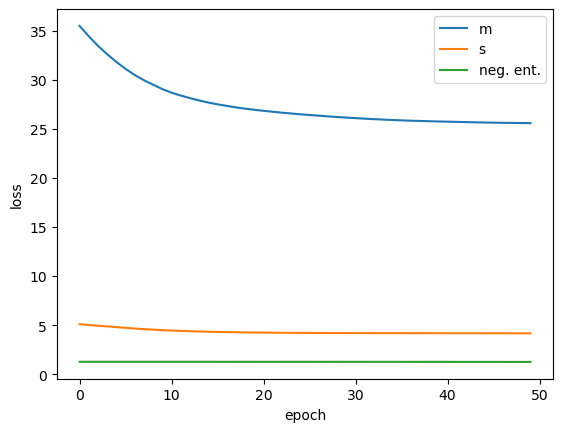

6 unique trees were not found (5 were found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

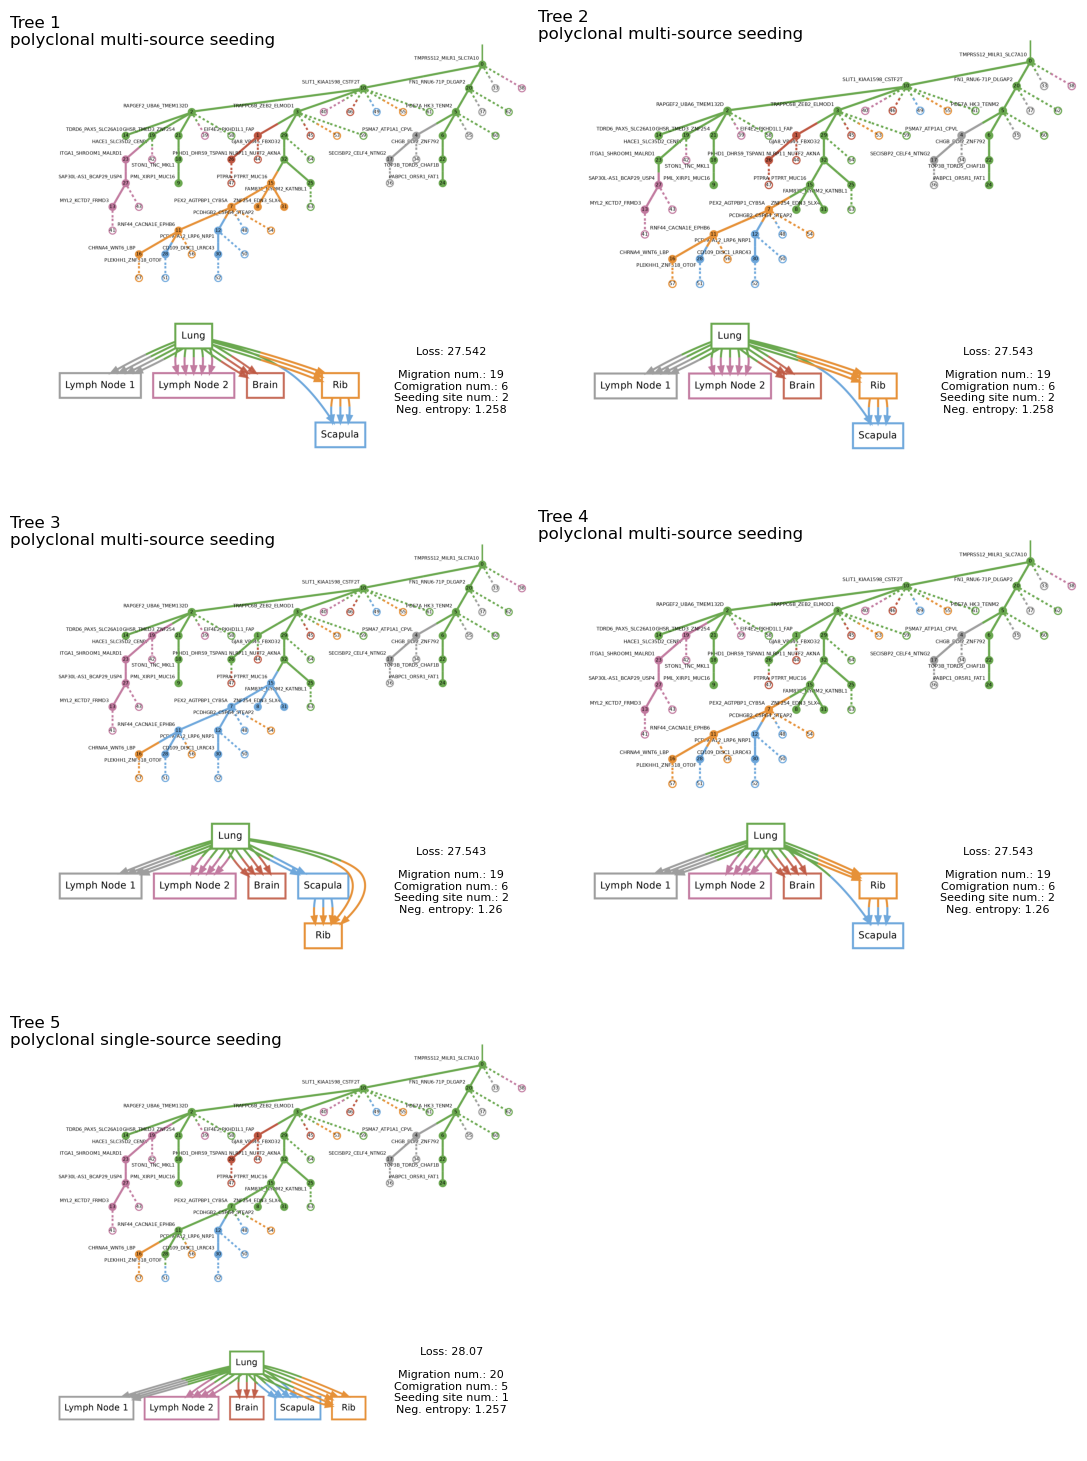

In [8]:
weights = Weights(mig=[100,1], mig_delta=0.8, seed_site=[1,10000], gen_dist=0.0, organotrop=0.0)
run_conipher_patient("CRUK0484", weights, PYCLONE_CLUSTERED_TSVS_DIR, CONIPHER_TREES_DIR, CRUK0484_msk_met_map, CRUK0484_tracerx_map, sites_map, OUTPUT_DIR)

### CRUK0236 with organotropism

In [6]:
%time
CRUK0236_tracerx_map = {
    "primary_SU_T1" : "Lung",
    "LN_SU_FLN1" : "Primary LN",
}

CRUK0236_msk_met_map = {
    "primary_SU_T1" : "Lung",
    "LN_SU_FLN1" : "Distant LN",
}

# For visualization on migraiton graph
sites_map = {
    "primary_SU_T1" : "Lung",
    "LN_SU_FLN1" : "Lymph Node",
}

weights = Weights(data_fit=0.2, mig=10.0, comig=7.0, seed_site=5.0, reg=3.0, gen_dist=2.0, organotrop=5.0)
run_conipher_patient("CRUK0236", weights, PYCLONE_CLUSTERED_TSVS_DIR, CONIPHER_TREES_DIR, CRUK0236_msk_met_map, CRUK0236_tracerx_map, sites_map, OUTPUT_DIR)

CPU times: user 0 ns, sys: 9 µs, total: 9 µs
Wall time: 14.5 µs


TypeError: __init__() got an unexpected keyword argument 'comig'

### CRUK0236 without organotropism

In [ ]:
weights = Weights(data_fit=0.2, mig=10.0, comig=7.0, seed_site=5.0, reg=3.0, gen_dist=2.0, organotrop=0.0)
run_conipher_patient("CRUK0236", weights, PYCLONE_CLUSTERED_TSVS_DIR, CONIPHER_TREES_DIR, CRUK0236_msk_met_map, CRUK0236_tracerx_map, sites_map, OUTPUT_DIR)

### CRUK0590 with organotropism

In [ ]:
%time
CRUK0590_tracerx_map = {
    "primary_SU_T1" : "Lung",
    "LN_SU_FLN1" : "Primary LN",
    "metachronousMet_BR_T1.FR1": "Brain",
    "metachronousMet_BR_T1.FR2": "Brain",
    "metachronousMet_BR_T3.FR1": "Brain",
}

CRUK0590_msk_met_map = {
    "primary_SU_T1" : "Lung",
    "LN_SU_FLN1" : "Distant LN",
    "metachronousMet_BR_T1.FR1": "Brain",
    "metachronousMet_BR_T1.FR2": "Brain",
    "metachronousMet_BR_T3.FR1": "Brain",
}

# For visualization on migraiton graph
sites_map = {
    "primary_SU_T1" : "Lung",
    "LN_SU_FLN1" : "Primary LN",
    "metachronousMet_BR_T1.FR1": "Brain 1",
    "metachronousMet_BR_T1.FR2": "Brain 2",
    "metachronousMet_BR_T3.FR1": "Brain 3",
}

weights = Weights(data_fit=0.2, mig=10.0, comig=7.0, seed_site=5.0, reg=3.0, gen_dist=2.0, organotrop=2.0)
run_conipher_patient("CRUK0590", weights, PYCLONE_CLUSTERED_TSVS_DIR, CONIPHER_TREES_DIR, CRUK0590_msk_met_map, CRUK0590_tracerx_map, sites_map, OUTPUT_DIR)

### CRUK0590 without organotropism

In [ ]:
weights = Weights(data_fit=0.2, mig=10.0, comig=7.0, seed_site=5.0, reg=3.0, gen_dist=2.0, organotrop=0.0)
run_conipher_patient("CRUK0590", weights, PYCLONE_CLUSTERED_TSVS_DIR, CONIPHER_TREES_DIR, CRUK0590_msk_met_map, CRUK0590_tracerx_map, sites_map, OUTPUT_DIR)

### CRUK0559 with organotropism

In [ ]:
%time
CRUK0559_tracerx_map = {
    "primary_SU_T1" : "Lung",
    "LN_SU_FLN1" : "Primary LN",
    "LN_SU_LN1" : "Primary LN",
    "LN_SU_LN2" : "Primary LN",
    "LN_SU_LN3" : "Primary LN",
    "metachronousMet_BR_T1" : "Recurrence LN",
}

CRUK0559_msk_met_map = {
    "primary_SU_T1" : "Lung",
    "LN_SU_FLN1" : "Distant LN",
    "LN_SU_LN1" : "Distant LN",
    "LN_SU_LN2" : "Distant LN",
    "LN_SU_LN3" : "Distant LN",
    "metachronousMet_BR_T1" : "Distant LN",
}

# For visualization on migraiton graph
sites_map = {
    "primary_SU_T1" : "Lung",
    "LN_SU_FLN1" : "Lymph Node 1",
    "LN_SU_LN1" : "Lymph Node 2",
    "LN_SU_LN2" : "Lymph Node 3",
    "LN_SU_LN3" : "Lymph Node 4",
    "metachronousMet_BR_T1" : "Lymph Node 5",
}

weights = Weights(data_fit=0.2, mig=10.0, comig=7.0, seed_site=5.0, reg=3.0, gen_dist=2.0, organotrop=5.0)
run_conipher_patient("CRUK0559", weights, PYCLONE_CLUSTERED_TSVS_DIR, CONIPHER_TREES_DIR, CRUK0559_msk_met_map, CRUK0559_tracerx_map, sites_map, OUTPUT_DIR)

### CRUK0559 without organotropism

In [ ]:
weights = Weights(data_fit=0.2, mig=10.0, comig=7.0, seed_site=5.0, reg=3.0, gen_dist=2.0, organotrop=0.0)
run_conipher_patient("CRUK0559", weights, PYCLONE_CLUSTERED_TSVS_DIR, CONIPHER_TREES_DIR, CRUK0559_msk_met_map, CRUK0559_tracerx_map, sites_map, OUTPUT_DIR)